# Time Series Forecasting with Linear Learner
_**Using Linear Regression to Forecast Monthly Demand**_

---

---

## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Host](#Host)
  1. [Forecast](#Forecast)
1. [Extensions](#Extensions)

---

## Background

Forecasting is potentially the most broadly relevant machine learning topic there is.  Whether predicting future sales in retail, housing prices in real estate, traffic in cities, or patient visits in healthcare, almost every industry could benefit from improvements in their forecasts.  There are numerous statistical methodologies that have been developed to forecast time-series data, but still, the process for developing forecasts tends to be a mix of objective statistics and subjective interpretations.

Properly modeling time-series data takes a great deal of care.  What's the right level of aggregation to model at?  Too granular and the signal gets lost in the noise, too aggregate and important variation is missed.  Also, what is the right cyclicality?  Daily, weekly, monthly?  Are there holiday peaks?  How should we weight recent versus overall trends?

Linear regression with appropriate controls for trend, seasonality, and recent behavior, remains a common method for forecasting stable time-series with reasonable volatility.  

# This notebook will build a linear model to forecast weekly output for US gasoline products starting in 1991 to 2005.  It will focus almost exclusively on the application.  For a more in-depth treatment on forecasting in general, see [Forecasting: Principles & Practice](https://robjhyndman.com/uwafiles/fpp-notes.pdf).  In addition, because our dataset is a single time-series, we'll stick with SageMaker's Linear Learner algorithm.  If we had multiple, related time-series, we would use SageMaker's DeepAR algorithm, which is specifically designed for forecasting.  See the [DeepAR Notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/deepar_synthetic/deepar_synthetic.ipynb) for more detail.

---

## Setup

_This notebook was created and tested on an ml.m4.xlarge notebook instance._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [1]:
# bucket = '<your_s3_bucket_name_here>'
prefix = 'sagemaker/DEMO-linear-time-series-forecast'

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role
import mxnet

# role = get_execution_role()
role = 'arn:aws:iam::558157414092:role/service-role/AmazonSageMaker-ExecutionRole-20200523T082014'
bucket = 'md-backup-bucket-01'


Now we'll import the Python libraries we'll need.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import time
import json
import sagemaker.amazon.common as smac
import sagemaker
from sagemaker.predictor import csv_serializer, json_deserializer

---
## Data

Let's download the data.  More information about this dataset can be found [here](https://rdrr.io/github/robjhyndman/fpp/man/gasoline.html).

In [4]:
!wget http://robjhyndman.com/data/gasoline.csv

--2020-05-27 13:36:12--  http://robjhyndman.com/data/gasoline.csv
Resolving robjhyndman.com (robjhyndman.com)...35.208.79.31
Connecting to robjhyndman.com (robjhyndman.com)|35.208.79.31|:80...connected.
HTTP request sent, awaiting response...301 Moved Permanently
Location: https://robjhyndman.com/data/gasoline.csv [following]
--2020-05-27 13:36:13--  https://robjhyndman.com/data/gasoline.csv
Connecting to robjhyndman.com (robjhyndman.com)|35.208.79.31|:443...connected.
HTTP request sent, awaiting response...200 OK
Length: 4530 (4.4K) [text/csv]
Saving to: ‘gasoline.csv’

gasoline.csv        100%[===================>]   4.42K  --.-KB/s    in 0s      

2020-05-27 13:36:13 (623 MB/s) - ‘gasoline.csv’ saved [4530/4530]



And take a look at it.

,thousands_barrels
0,6621.0
1,6433.0
2,6582.0
3,7224.0
4,6875.0


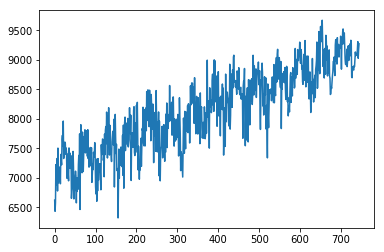

In [5]:
gas = pd.read_csv('gasoline.csv', header=None, names=['thousands_barrels'])
display(gas.head())
plt.plot(gas)
plt.show()

As we can see, there's a definitive upward trend, some yearly seasonality, but sufficient volatility to make the problem non-trivial.  There are several unexpected dips and years with more or less pronounced seasonality.  These same characteristics are common in many topline time-series.

Next we'll transform the dataset to make it look a bit more like a standard prediction model.  Our target variable is `thousands_barrels`.  Let's create explanatory features, like:
- `thousands_barrels` for each of the 4 preceeding weeks.
- Trend.  The chart above suggests the trend is simply linear, but we'll create log and quadratic trends in case.
- Indicator variables {0 or 1} that will help capture seasonality and key holiday weeks.

In [6]:
gas['thousands_barrels_lag1'] = gas['thousands_barrels'].shift(1)
gas['thousands_barrels_lag2'] = gas['thousands_barrels'].shift(2)
gas['thousands_barrels_lag3'] = gas['thousands_barrels'].shift(3)
gas['thousands_barrels_lag4'] = gas['thousands_barrels'].shift(4)
gas



,thousands_barrels,thousands_barrels_lag1,thousands_barrels_lag2,thousands_barrels_lag3,thousands_barrels_lag4
0,6621.0,NaN,NaN,NaN,NaN
1,6433.0,6621.0,NaN,NaN,NaN
2,6582.0,6433.0,6621.0,NaN,NaN
3,7224.0,6582.0,6433.0,6621.0,NaN
4,6875.0,7224.0,6582.0,6433.0,6621.0
5,6947.0,6875.0,7224.0,6582.0,6433.0
6,7328.0,6947.0,6875.0,7224.0,6582.0
7,6777.0,7328.0,6947.0,6875.0,7224.0
8,7503.0,6777.0,7328.0,6947.0,6875.0
9,6916.0,7503.0,6777.0,7328.0,6947.0


In [7]:
gas['trend'] = np.arange(len(gas))
gas



,thousands_barrels,thousands_barrels_lag1,thousands_barrels_lag2,thousands_barrels_lag3,thousands_barrels_lag4,trend
0,6621.0,NaN,NaN,NaN,NaN,0
1,6433.0,6621.0,NaN,NaN,NaN,1
2,6582.0,6433.0,6621.0,NaN,NaN,2
3,7224.0,6582.0,6433.0,6621.0,NaN,3
4,6875.0,7224.0,6582.0,6433.0,6621.0,4
5,6947.0,6875.0,7224.0,6582.0,6433.0,5
6,7328.0,6947.0,6875.0,7224.0,6582.0,6
7,6777.0,7328.0,6947.0,6875.0,7224.0,7
8,7503.0,6777.0,7328.0,6947.0,6875.0,8
9,6916.0,7503.0,6777.0,7328.0,6947.0,9


In [8]:
gas['log_trend'] = np.log1p(np.arange(len(gas)))
gas



,thousands_barrels,thousands_barrels_lag1,thousands_barrels_lag2,thousands_barrels_lag3,thousands_barrels_lag4,trend,log_trend
0,6621.0,NaN,NaN,NaN,NaN,0,0.000000
1,6433.0,6621.0,NaN,NaN,NaN,1,0.693147
2,6582.0,6433.0,6621.0,NaN,NaN,2,1.098612
3,7224.0,6582.0,6433.0,6621.0,NaN,3,1.386294
4,6875.0,7224.0,6582.0,6433.0,6621.0,4,1.609438
5,6947.0,6875.0,7224.0,6582.0,6433.0,5,1.791759
6,7328.0,6947.0,6875.0,7224.0,6582.0,6,1.945910
7,6777.0,7328.0,6947.0,6875.0,7224.0,7,2.079442
8,7503.0,6777.0,7328.0,6947.0,6875.0,8,2.197225
9,6916.0,7503.0,6777.0,7328.0,6947.0,9,2.302585


In [9]:
gas['sq_trend'] = np.arange(len(gas)) ** 2

weeks = pd.get_dummies(np.array(list(range(52)) * 15)[:len(gas)], prefix='week')

gas = pd.concat([gas, weeks], axis=1)
gas

,thousands_barrels,thousands_barrels_lag1,thousands_barrels_lag2,thousands_barrels_lag3,thousands_barrels_lag4,trend,log_trend,sq_trend,week_0,week_1,...,week_42,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51
0,6621.0,NaN,NaN,NaN,NaN,0,0.000000,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,6433.0,6621.0,NaN,NaN,NaN,1,0.693147,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,6582.0,6433.0,6621.0,NaN,NaN,2,1.098612,4,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7224.0,6582.0,6433.0,6621.0,NaN,3,1.386294,9,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6875.0,7224.0,6582.0,6433.0,6621.0,4,1.609438,16,0,0,...,0,0,0,0,0,0,0,0,0,0
5,6947.0,6875.0,7224.0,6582.0,6433.0,5,1.791759,25,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7328.0,6947.0,6875.0,7224.0,6582.0,6,1.945910,36,0,0,...,0,0,0,0,0,0,0,0,0,0
7,6777.0,7328.0,6947.0,6875.0,7224.0,7,2.079442,49,0,0,...,0,0,0,0,0,0,0,0,0,0
8,7503.0,6777.0,7328.0,6947.0,6875.0,8,2.197225,64,0,0,...,0,0,0,0,0,0,0,0,0,0
9,6916.0,7503.0,6777.0,7328.0,6947.0,9,2.302585,81,0,0,...,0,0,0,0,0,0,0,0,0,0


Now, we'll:
- Clear out the first four rows where we don't have lagged information.
- Split the target off from the explanatory features.
- Split the data into training, validation, and test groups so that we can tune our model and then evaluate its accuracy on data it hasn't seen yet.  Since this is time-series data, we'll use the first 60% for training, the second 20% for validation, and the final 20% for final test evaluation.

In [10]:
gas = gas.iloc[4:, ]

split_train = int(len(gas) * 0.6)
split_test = int(len(gas) * 0.8)

train_y = gas['thousands_barrels'][:split_train]
train_X = gas.drop('thousands_barrels', axis=1).iloc[:split_train, ].as_matrix()
validation_y = gas['thousands_barrels'][split_train:split_test]
validation_X = gas.drop('thousands_barrels', axis=1).iloc[split_train:split_test, ].as_matrix()
test_y = gas['thousands_barrels'][split_test:]
test_X = gas.drop('thousands_barrels', axis=1).iloc[split_test:, ].as_matrix()

Now, we'll convert the datasets to the recordIO-wrapped protobuf format used by the Amazon SageMaker algorithms and upload this data to S3.  We'll start with training data.

In [11]:
buf = io.BytesIO()

smac.write_numpy_to_dense_tensor(buf, np.array(train_X).astype('float32'), np.array(train_y).astype('float32'))

buf.seek(0)

0

In [12]:
key = 'linear_train.data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://md-backup-bucket-01/sagemaker/DEMO-linear-time-series-forecast/train/linear_train.data


Next we'll convert and upload the validation dataset.

In [13]:
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, np.array(validation_X).astype('float32'), np.array(validation_y).astype('float32'))
buf.seek(0)

0

In [14]:
key = 'linear_validation.data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation', key)).upload_fileobj(buf)
s3_validation_data = 's3://{}/{}/validation/{}'.format(bucket, prefix, key)
print('uploaded validation data location: {}'.format(s3_validation_data))

uploaded validation data location: s3://md-backup-bucket-01/sagemaker/DEMO-linear-time-series-forecast/validation/linear_validation.data


---
## Train

Now we can begin to specify our linear model.  First, let's specify the containers for the Linear Learner algorithm.  Since we want this notebook to run in all of Amazon SageMaker's regions, we'll use a convenience function to look up the container image name for our current region.  More details on algorithm containers can be found in [AWS documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html).

In [15]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'linear-learner')

Amazon SageMaker's Linear Learner actually fits many models in parallel, each with slightly different hyperparameters, and then returns the one with the best fit.  This functionality is automatically enabled.  We can influence this using parameters like:

- `num_models` to increase to total number of models run.  The specified parameters will always be one of those models, but the algorithm also chooses models with nearby parameter values in order to find a solution nearby that may be more optimal.  In this case, we're going to use the max of 32.

- `loss` which controls how we penalize mistakes in our model estimates.  For this case, let's use absolute loss as we haven't spent much time cleaning the data, and absolute loss will adjust less to accomodate outliers.

- `wd` or `l1` which control regularization.  Regularization can prevent model overfitting by preventing our estimates from becoming too finely tuned to the training data, which can actually hurt generalizability.  In this case, we'll leave these parameters as their default "auto" though.


Let'd kick off our training job in SageMaker's distributed, managed training.  Because training is managed (AWS handles spinning up and spinning down hardware), we don't have to wait for our job to finish to continue, but for this case, we'll use the Python SDK to track to wait and track our progress.

In [16]:
sess = sagemaker.Session()

linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path='s3://{}/{}/output'.format(bucket, prefix),
                                       sagemaker_session=sess)

linear.set_hyperparameters(feature_dim=59,
                           mini_batch_size=100,
                           predictor_type='regressor',
                           epochs=10,
                           num_models=32,
                           loss='absolute_loss')

linear.fit({'train': s3_train_data, 'validation': s3_validation_data})

bsolute_loss_objective": {"count": 1, "max": 0.4385811710357666, "sum": 0.4385811710357666, "min": 0.4385811710357666}}, "EndTime": 1590588077.653936, "Dimensions": {"model": 19, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1590588077.65393}

#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 0.4898873043060303, "sum": 0.4898873043060303, "min": 0.4898873043060303}}, "EndTime": 1590588077.653962, "Dimensions": {"model": 20, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1590588077.653955}

#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 0.49913992881774905, "sum": 0.49913992881774905, "min": 0.49913992881774905}}, "EndTime": 1590588077.653986, "Dimensions": {"model": 21, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1590588077.65398}

#metrics {"Metrics": {"train_absolute_loss

---
## Host

Now that we've trained the linear algorithm on our data, let's create a model and deploy that to a hosted endpoint.

In [ ]:
linear_predictor = linear.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

### Forecast

Now that we have our hosted endpoint, we can generate statistical forecasts from it.  Let's forecast on our test dataset to understand how accurate our model may be.

There are many metrics to measure forecast error.  Common examples include include:
- Root Mean Square Error (RMSE)
- Mean Absolute Percent Error (MAPE)
- Geometric Mean of the Relative Absolute Error (GMRAE)
- Quantile forecast errors
- Errors that account for asymmetric loss in over or under-prediction

For our example we'll keep things simple and use Median Absolute Percent Error (MdAPE), but we'll also compare it to a naive benchmark forecast (that week last year's demand * that week last year / that week two year's ago).

There are also multiple ways to generate forecasts.
- One-step-ahead forecasts:  When predicting for multiple data points, one-step-ahead forecasts update the history with the correct known value.  These are common, easy to produce, and can give us some intuition of whether out model is performing as expected.  However, they can also present an unnecessarily optimistic evaluation of the forecast.  In most real-life cases, we want to predict out well into the future, because the actions we may take based on that forecast are not immediate.  In these cases, we want know what the time-periods in between will bring, so generating a forecast based on the knowledge that we do, can be misleading.
- Multi-step-ahead (or horizon) forecasts: In this case, when forecasting out of sample, each forecast builds off of the forecasted periods that precede it.  So, errors early on in the test data can compound to create large deviations for observations late in the test data.  Although this is more realistic, it can be difficult to create the forecasts, particularly as model complexity increases.

For our example, we'll calculate both, but focus on the multi-step forecast accuracy.

Let's start by generating the naive forecast.

In [ ]:
gas['thousands_barrels_lag52'] = gas['thousands_barrels'].shift(52)
gas['thousands_barrels_lag104'] = gas['thousands_barrels'].shift(104)
gas['thousands_barrels_naive_forecast'] = gas['thousands_barrels_lag52'] ** 2 / gas['thousands_barrels_lag104']
naive = gas[split_test:]['thousands_barrels_naive_forecast'].as_matrix()

And investigating it's accuracy.

In [ ]:
print('Naive MdAPE =', np.median(np.abs(test_y - naive) / test_y))
plt.plot(np.array(test_y), label='actual')
plt.plot(naive, label='naive')
plt.legend()
plt.show()

Now we'll generate the one-step-ahead forecast.  First we need a function to convert our numpy arrays into a format that can be handled by the HTTP POST request we pass to the inference container.  In this case that's a simple CSV string.  The results will be published back as JSON.  For these common formats we can use the Amazon SageMaker Python SDK's built in `csv_serializer` and `json_deserializer` functions. 

In [ ]:
linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer

Next, we'll invoke the endpoint to get predictions.

In [ ]:
result = linear_predictor.predict(test_X)
one_step = np.array([r['score'] for r in result['predictions']])

Let's compare forecast errors.

In [ ]:
print('One-step-ahead MdAPE = ', np.median(np.abs(test_y - one_step) / test_y))
plt.plot(np.array(test_y), label='actual')
plt.plot(one_step, label='forecast')
plt.legend()
plt.show()

As we can see our MdAPE is substantially better than the naive, and we actually swing from a forecasts that's too volatile to one that under-represents the noise in our data.  However, the overall shape of the statistical forecast does appear to better represent the actual data.

Next, let's generate multi-step-ahead forecast.  To do this, we'll need to loop over invoking the endpoint one row at a time and make sure the lags in our model are updated appropriately.

In [ ]:
multi_step = []
lags = test_X[0, 0:4]
for row in test_X:
    row[0:4] = lags
    result = linear_predictor.predict(row)
    prediction = result['predictions'][0]['score']
    multi_step.append(prediction)
    lags[1:4] = lags[0:3]
    lags[0] = prediction

multi_step = np.array(multi_step)

And now calculate the accuracy of these predictions.

In [ ]:
print('Multi-step-ahead MdAPE =', np.median(np.abs(test_y - multi_step) / test_y))
plt.plot(np.array(test_y), label='actual')
plt.plot(multi_step, label='forecast')
plt.legend()
plt.show()

As we can see our multi-step ahead error performs worse than our one-step ahead forecast, but nevertheless remains substantially stronger than the naive benchmark forecast.  This 1.5 percentage point difference may not seem particularly meaningful, but at the large scale of many topline forecasts can mean millions of dollars in excess supply or lost sales.

---
## Extensions

Our linear model does a good job of predicting gasoline demand, but of course, improvements could be made.  The fact that statistical forecast actually underrepresents some of the volatility in the data could suggest that we have actually over-regularized the data.  Or, perhaps our choice of absolute loss was incorrect.  Rerunning the model with further tweaks to these hyperparameters may provide more accurate out of sample forecasts.  We also did not do a large amount of feature engineering.  Occasionally, the lagging time-periods have complex interrelationships with one another that should be explored.  Finally, alternative forecasting algorithms could be explored.  Less interpretable methods like ARIMA, and black-box methods like LSTM Recurrent Neural Networks have been shown to predict time-series very well.  Balancing the simplicity of a linear model with predictive accuracy is an important subjective question where the right answer depends on the problem being solved, and its implications to the business.

### (Optional) Clean-up

If you're ready to be done with this notebook, please run the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [ ]:
sagemaker.Session().delete_endpoint(linear_predictor.endpoint)